# Models for Quality and Condition: Ames, Iowa

This notebook will encompass pre-processing and feature engineering the data that was cleaned in the 01_EDA_and_Cleaning notebook.  There are some features containing ordinal data that will need to be treated.  

The main goal of this modeling is to provide decision support and any key insights to the Associated General Contractors of Iowa so they can choose whether to proceed with a marketing campaign centered around remodeling and home improvement to drive increased business for Ames, Iowa contractors.  As such, features relating to quality of materials and craftsmanship as well as condition of various rooms, exterior, and kitchen will be examined.  These models are not expected to predict price, but to be used to study what affects these different features may have on housing sale prices or trends for the marketing campaign, if funded.

The various models that are produced will be scored and then one model will be selected as the model to use for interpreting the results and providing insight for the selected features.  

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# imports for transforming, modeling, and scoring
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, \
ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# imports for q-q plots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# imports and code for warning suppression
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Import data

In [2]:
train = pd.read_csv('../data/train_cleaned.csv')
test = pd.read_csv('../data/test_cleaned.csv')

In [3]:
train.head(3)

,id,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,lot_config,land_slope,neighborhood,bldg_type,...,enclosed_porch,3ssn_porch,screen_porch,yr_sold,sale_type,saleprice,tot_baths,tot_sf,bsmt_fin_sf,bsmt_pct_fin
0,109,RL,68.0,13517,IR1,Lvl,CulDSac,Gtl,Sawyer,1Fam,...,0,0,0,2010,WD,130500,2.5,2204.0,533.0,73.517241
1,544,RL,43.0,11492,IR1,Lvl,CulDSac,Gtl,SawyerW,1Fam,...,0,0,0,2009,WD,220000,3.5,3035.0,637.0,69.769989
2,153,RL,68.0,7922,Reg,Lvl,Inside,Gtl,NAmes,1Fam,...,0,0,0,2010,WD,109000,2.0,2114.0,731.0,69.157994


In [4]:
test.head(3)

,id,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,lot_config,land_slope,neighborhood,bldg_type,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,yr_sold,sale_type,tot_baths,tot_sf,bsmt_fin_sf,bsmt_pct_fin
0,2658,RM,69.0,9142,Reg,Lvl,Inside,Gtl,OldTown,2fmCon,...,60,112,0,0,2006,WD,2.0,2948,0,0.00000
1,2718,RL,68.0,9662,IR1,Lvl,Inside,Gtl,Sawyer,Duplex,...,0,0,0,0,2006,WD,2.0,3934,0,0.00000
2,2414,RL,58.0,17104,IR1,Lvl,Inside,Gtl,Gilbert,1Fam,...,24,0,0,0,2006,New,3.5,2150,554,84.70948


In [5]:
train.columns

Index(['id', 'ms_zoning', 'lot_frontage', 'lot_area', 'lot_shape',
       'land_contour', 'lot_config', 'land_slope', 'neighborhood', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd',
       'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'low_qual_fin_sf',
       'gr_liv_area', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_finish', 'garage_area', 'garage_qual',
       'garage_cond', 'paved_drive', 'wood_deck_sf', 'open_porch_sf',
       'enclosed_porch', '3ssn_porch', 'screen_porch', 'yr_sold', 'sale_type',
       'saleprice', 'tot_baths', 'tot_sf', 'bsmt_fin_sf', 'bsmt_pct_fin'],
      dtype='o

In [6]:
train.shape

(2046, 60)

In [7]:
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

## Preprocessing Quality and Condition Features

In our analysis we're focusing largely on condition and quality.  Features to convert categorical data to numeric data:
- Exterior Condition
- Exterior Quality
- Basement Condition
- Basement Quality
- Kitchen Quality
- Garage Condition
- Garage Quality

One of the things that I think will happen with one or more of the columns is that we will convert ordinal categorical values to numerical ones.  I will define a function that can take a specific dictionary of the mapping of values to numbers so that this can be applied and re-used as necessary for certain features.

In addition, I will plan on encoding some of the categorical values such as neighborhood for the model.

Pull the mapping from the data description since we'll build one dictionary per mapping needed.

The following features all have the same scale of:
- `Exter Qual` (Ordinal): Evaluates the quality of the material on the exterior 
- `Exter Cond` (Ordinal): Evaluates the present condition of the material on the exterior
- `KitchenQual` (Ordinal): Kitchen quality
- Scale:
    - Ex	Excellent
    - Gd	Good
    - TA	Average/Typical
    - Fa	Fair
    - Po	Poor

The remaining features have a different, but similar scale:
- `Bsmt Qual` (Ordinal): Evaluates the height of the basement
- `Bsmt Cond` (Ordinal): Evaluates the general condition of the basement
- `Garage Qual` (Ordinal): Garage quality
- `Garage Cond` (Ordinal): Garage condition

    - Ex	Excellent
    - Gd	Good
    - TA	Typical
    - Fa	Fair
    - Po	Poor
    - NA	No Basement/Garage
 
It appears there is basically a 5 value map and 6 value map.  Since the values are mostly shared, I can just create one mapping dictionary. 

The what values these map to may be adjusted.  As there are overall quality and condition scales from the data set, such as:

Overall Qual (Ordinal): Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
       
I will start by mapping the 5-6 values to the 10 point scale.
- `Ex` will be mapped 10 since that is the highest of the excellent scale.
- `Gd` will be mapped to 8 which is the highest of the "good" values.
- `TA` will be mapped to 5 for average.
- `Fa` will be mapped to 3 for fair.
- `Po` will be mapped to 1 since that is the lowest of the poor scale.
- `no value` will be mapped to 0.

In [8]:
# note initial modeling was doing with 0-5 scale
# adjusting this now that I've spent more time on EDA
ord_map = {
    'Ex': 10,
    'Gd': 8,
    'TA': 5,
    'Fa': 3,
    'Po': 1,
    'no value': 0
}

Define a function that I can use to process the columns

In [9]:
def ord_to_num(x, dict_map):
    '''fn that takes value and map in the form of a dictionary that contains 
    the possible x values as keys and the wanted substituted value as the 
    value for that key. {value: substitute value} If there is no matching key 
    for the value, then the original value will be returned.
    '''
    
    return dict_map.get(x)

Apply the mapping function to the features in both the train and test data

In [10]:
for col in ['exter_cond', 
            'exter_qual', 
            'bsmt_qual', 
            'bsmt_cond', 
            'kitchen_qual',
            'garage_cond', 
            'garage_qual']:
    train[col] = train[col].apply(lambda x: ord_to_num(x, ord_map))
    test[col] = test[col].apply(lambda x: ord_to_num(x, ord_map))

## Quality and Condition Models

In this section, I'll create a baseline null model and then a simple linear regression for comparison points to see how future models differ from the baseline and simple linear regression model.  After that, I'll move to a multiple linear regression model, lasso, ridge, and elastic net models as necessary.  

After each model is created and trained, I'll perform some evaluation of the model, including checks for various assumptions and see how the affects of adding and transforming features changes the models.  

### Model Evaluation
For each model, I will score as described below:
- Obtain the cross validation score to inform what the expected scores should be for our model on training and validation data  
- Score the model using training data getting both R2 and RMSE
- Score the model using validation data getting both R2 and RMSE

For some models of interest, I will additionally:
- Make predictions with the model and calculate the residuals
- Plot the residuals against the predicted values to help evaluate the model
- Check the distribution of the errors

For my final model(s), I will also interpret the results as they relate to the problem statement.

### Define a Function to Calculate and Print Scores
As many models are going to be scored, compared, and tuned, defining this function to calculate the R2 score and the RMSE for a given set of y_true values and y_pred predictions.

In [11]:
# borrowed some of this from the regularlization lesson
def get_scores(y_true, y_pred):
    '''
    fn that takes y_true, y_pred then calculates and displays:
    - R2 score
    - RMSE (Root Mean Square Error)
    '''
    
    return (
        f'R2 score: {round(r2_score(y_true, y_pred), 2):.2f}',
        f'RMSE: {round(mean_squared_error(y_true, y_pred)**0.5, 2):.2f}'
    )

### Setup X, y, split

We'll start by configuring the data for a Simple Linear Regression with just one feature.  You'll see this process performed multiple times in the notebook, but allows me to split the data so I can train and validate the model.

Feature for Simple Linear Regression:
- total square feet (`tot_sf`)

In [12]:
#configure X and y with features and target
X = train[['tot_sf']]
y = train['saleprice']

# split for train and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=415)

### Create Null model
To create a baseline, we'll score a null model that is only using the mean of the sale price

In [13]:
base_null = [y_train.mean()]*len(y_val)
get_scores(y_val, base_null)

('R2 score: -0.00', 'RMSE: 75342.56')

Baseline null model has a zero for R2 which means that it is not describing the variance in the target value at all.  It follows with an RMSE of approximately \\$75,000 dollars.

### Simple Linear Regression

Instantiate and fit our training data to our linear regression model:

In [14]:
#instantiate model
slr = LinearRegression()

In [15]:
slr.fit(X_train, y_train)

LinearRegression()

#### Model Evaluation

Check cross validation score

In [16]:
# check cross val score
cross_val_score(slr, X_train, y_train, cv=5).mean()

0.6849429349117105

Score the model on training data

In [17]:
# slr train score
get_scores(y_train, slr.predict(X_train))

('R2 score: 0.69', 'RMSE: 44899.13')

Score the model on validation data

In [18]:
# slr val score
get_scores(y_val, slr.predict(X_val))

('R2 score: 0.65', 'RMSE: 44262.00')

This simple linear regression model improved quite a bit from the baseline with the RMSE coming down from ~75k dollars to ~44k dollars.  This simple model is also explaining about 65% of the target variation with the feature used. The R2 scores of .69 and .65 on the train and validation data are within a reasonable range given the cross validation score mean of .685.

Make predictions using the simple linear regression model and calculate the residuals

In [19]:
#calculate residuals by creating predictions
preds = slr.predict(X_train)
resid = y_train - preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

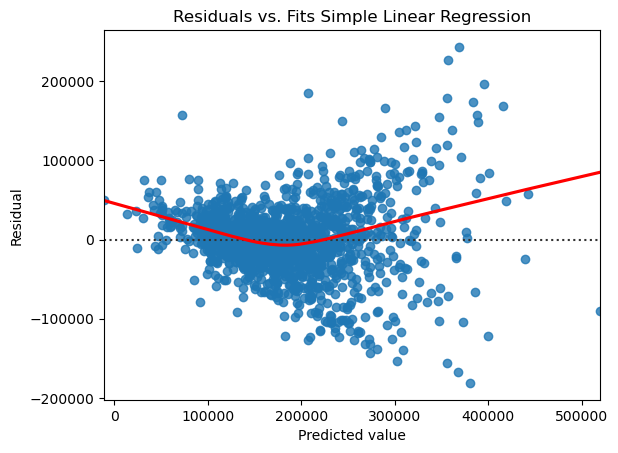

In [20]:
# from testing linear assumptions bh lesson
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits Simple Linear Regression',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

As the predicted value increase the error also increases in dispersion, so this model isn't explaining the data very well.  There are also some very large positive residuals, even in lower predicted values.

Checking residual/error normality

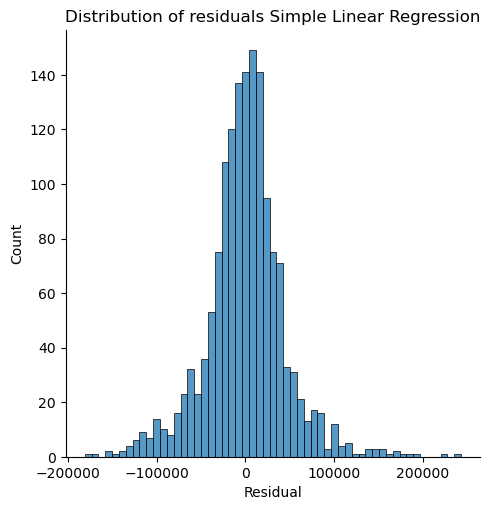

In [21]:
sns.displot(resid)\
    .set(title = 'Distribution of residuals Simple Linear Regression',
        xlabel = 'Residual');

The residuals do look approximately normally distributed, but it appears that there are some residuals further on the positive side of the distribution which looks like a right skew.  This matches what we were seeing in the prior residuals plot where there was a wider variance in the error as the predicted price increased, but also that there were large positive residuals throughout the entire predicted value range.

### Multiple Linear Regression

For this multiple linear regression model, additional features will be added to the model.  We will add all the quality and condition features that is the focus of this investigation, as well as features that were identified during EDA as potentially correlated to the sale price.  Since I am trying to focus on what can be improved for the property I will leave out total basement square feet, as those adding square feet is much more costly than finishing or remodeling a basement space:

In [22]:
#configure X and y with features and target
X = train[['tot_baths', 
            'bedroom_abvgr', 
            'gr_liv_area',
            'overall_qual',
            'overall_cond',
            'garage_area',
            'exter_cond', 
            'exter_qual', 
            'bsmt_qual', 
            'bsmt_cond',
            'bsmt_fin_sf',
            'bsmt_pct_fin',
            'kitchen_qual',
            'garage_cond', 
            'garage_qual',
            'fireplaces'
          ]]


y = train['saleprice']

# split for train and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=415)

Instantiate and train the model

In [23]:
#instantiate model
mlr = LinearRegression()

In [24]:
mlr.fit(X_train, y_train)

LinearRegression()

#### Model Evaluation

Check cross validation score

In [25]:
# check cross val score
cross_val_score(mlr, X_train, y_train, cv=5).mean()

0.8549641532585432

Score the model on training data

In [26]:
# mlr train score
get_scores(y_train, mlr.predict(X_train))

('R2 score: 0.86', 'RMSE: 30036.96')

Score the model on validation data

In [27]:
# mlr val score
get_scores(y_val, mlr.predict(X_val))

('R2 score: 0.86', 'RMSE: 28005.72')

This multiple linear regression model improved on the SLR model lowering the RMSE to ~ \\$28k dollars from ~ \\$44k dollars. This model is also explaining about 85% of the target variation with the features used. The R2 scores of .86 on the train and validation data are right in line based on the cross validation score mean of .85.

Looking at the features and coefficients for this model:

In [28]:
# inspiration from SO
# https://stackoverflow.com/questions/34649969/how-to-find-the-features-names-of-the-coefficients-using-scikit-linear-regressio

{feature: f'{coef:.2f}' for feature, coef in 
 zip(mlr.feature_names_in_, mlr.coef_)}

{'tot_baths': '-1385.78',
 'bedroom_abvgr': '-1995.89',
 'gr_liv_area': '55.85',
 'overall_qual': '12823.41',
 'overall_cond': '4640.23',
 'garage_area': '57.90',
 'exter_cond': '-1956.00',
 'exter_qual': '5551.42',
 'bsmt_qual': '4490.46',
 'bsmt_cond': '-1635.86',
 'bsmt_fin_sf': '69.18',
 'bsmt_pct_fin': '-487.24',
 'kitchen_qual': '3685.34',
 'garage_cond': '-4077.32',
 'garage_qual': '1855.07',
 'fireplaces': '6009.75'}

There are some interesting values here, especially the negative values for bedrooms, exterior condition, basement condition, and garage condition.  I suspect that there is some collinearity between some of these features. I'll move to a Lasso model next and see which features it may select.

To investigate collinearity, I'll check both the correlation heatmap, but also calculate the Variance Inflaction Factor.

Plotting heatmap of correlation between features:

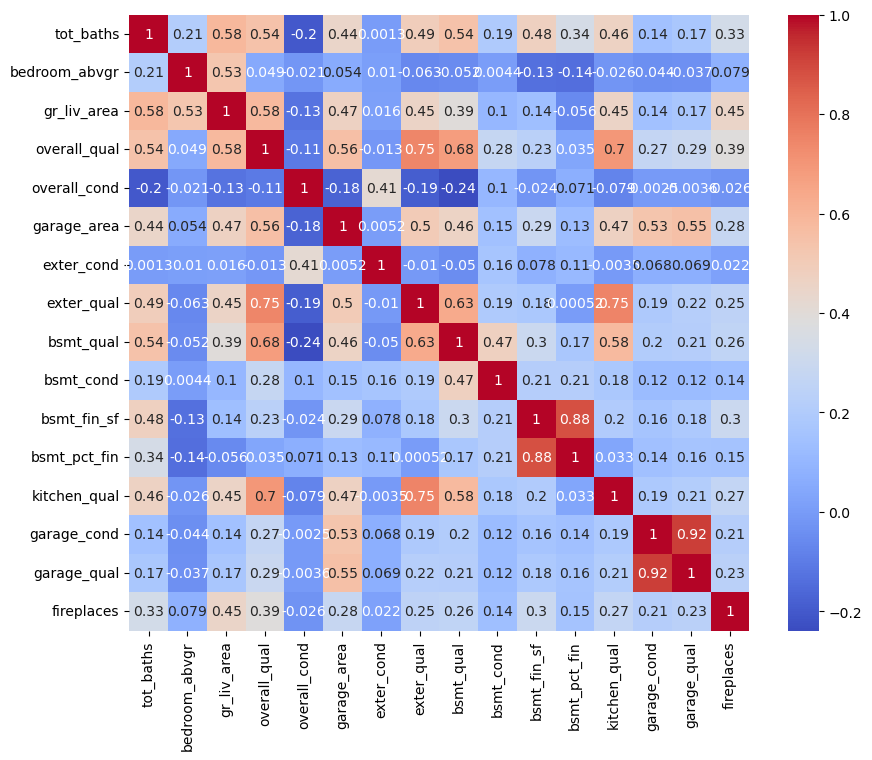

In [29]:
plt.figure(figsize = (10,8))
sns.heatmap(X_train.corr(),
            annot = True,
            cmap = 'coolwarm'
           );

This heatmap is a visualization of the pearson correlation coefficient which describes linear relationships.  The closer the value is to 1 the stronger the correlation.  From my experience, when looking at features like this, a value above .8 I would consider to be fairly strong.  

From the above heatmap it looks like garage_qual and garage_cond have a strong correlation, which seems like a reasonable relationship. Also, bsmt_fin_sf and bsmt_pct_fin have a correlation of .88 which is also strong and is also logical that they would be collinear. 

Since none of the other values appear to be above .8, I'll move to another method to try and identify features that are correlated to each other, Variance Inflation Factor (VIF).

#### Variance Inflation Factor

To check for collinearity between the selected features, we'll check the variance inflation factors.

Below is a function that iterates through the values in the model, calculates the VIF, and then returns all the features and their related VIF as a dataframe. (borrowed from breakfast hour lesson)

In [30]:
# function from the testing linear assumptions bh
#to get our nice dataframe again, we can again define a function
def calc_vif(data):
    v_df = pd.DataFrame(columns = ['vif'],
                       index = data.columns)
    
    v_df['vif'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    
    return v_df.sort_values(by = 'vif', ascending = False)

In [31]:
calc_vif(X_train)

,vif
garage_cond,104.127206
garage_qual,104.013056
overall_qual,68.871913
exter_qual,48.386432
kitchen_qual,36.994709
gr_liv_area,36.019065
overall_cond,34.445097
exter_cond,33.505449
bsmt_cond,31.060338
bsmt_qual,30.615814


At a high level this test is basically running a simple linear regression between a feature against the rest.  The function will iterate through all of them.  How the score is calculated means that the higher the VIF, the stronger the correlation is.

Ideally these scores would be < ~5, so there does appear to be some collinearity between some features.  As that violates the assumptions required for linear regression, I'm not going to proceed with the rest of the model validation, and move this data to a Lasso and see which features might be eliminated.

Usually, you would remove the feature with the highest score and then re-calculate until all the values are in the desired range.  Since this particular model is being generated and will later be improved on, I won't go through this now.

Make predictions using the multiple linear regression model and calculate the residuals

In [32]:
#calculate residuals by creating predictions
preds = mlr.predict(X_train)
resid = y_train - preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

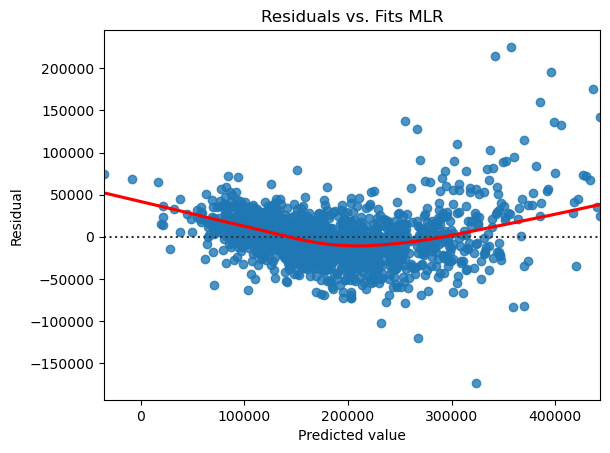

In [33]:
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits MLR',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

Compared to the simple linear regression, you can observe that the errors are becoming more homoscedastic.  The errors are also getting a bit closer to zero which is certainly an improvement.  We still see that as the predicted value increase the error also increases in dispersion, but the spread isn't as significant as the previous model--this is an improvement over the first SLR model.

Checking residual/error normality

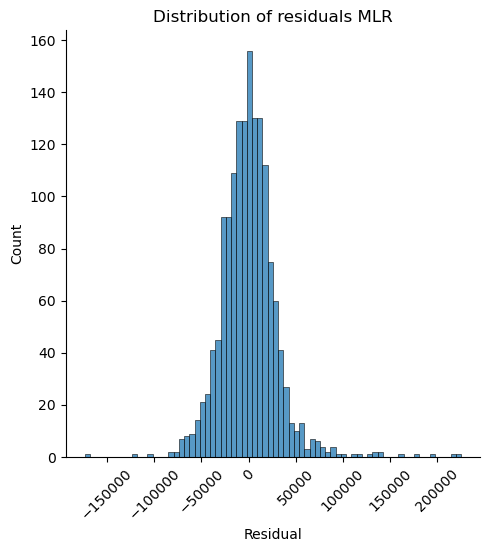

In [34]:
sns.displot(resid)\
    .set(title = 'Distribution of residuals MLR',
        xlabel = 'Residual')

plt.xticks(rotation=45);

This plot is showing that the errors are approximately normally distributed, but the presence of those values of the high positive residuals appears as a right skew.

### Transform Data
Now that I've created simple and multiple linear regression models, to try and address the collinearity in the features we're examining, I will attempt to regularlize with lasso first and see which features may be zeroed out with the lasso penalty. Before I can use lasso, I need to standardize the data.  After this standardization, I'll check the MLR model once again, and then move to the lasso.

Create a new split from the existing X, y data:

In [35]:
# create a new split for scaled/standardized data
Xs_train, Xs_val, ys_train, ys_val = train_test_split(X, y, random_state=415)

Xs_train.shape, Xs_val.shape

((1534, 16), (512, 16))

In [36]:
Xs_train.head(3)

,tot_baths,bedroom_abvgr,gr_liv_area,overall_qual,overall_cond,garage_area,exter_cond,exter_qual,bsmt_qual,bsmt_cond,bsmt_fin_sf,bsmt_pct_fin,kitchen_qual,garage_cond,garage_qual,fireplaces
1707,2.0,3,894,5,7,450.0,5,5,5,5,702.0,78.523490,8,5,5,0
1645,2.0,3,1040,5,7,484.0,5,5,8,5,676.0,65.000000,8,5,5,0
606,3.5,4,2329,7,5,514.0,5,5,8,5,1085.0,73.559322,8,5,5,1


There aren't any categorical features in this quality and condition model dataframe, so we'll just need to standardize it.

To do this, I'll:
- Instantiate the StandardScaler
- Fit and transform based on my training data
- Transform my validation data

In [37]:
# instantiate standard scaler
ss = StandardScaler()

In [38]:
# fit and transform the train data, transform the val data
Xs_train = ss.fit_transform(Xs_train)
Xs_val = ss.transform(Xs_val)

In [39]:
# #recreate dataframes
Xs_train = pd.DataFrame(Xs_train, columns=ss.get_feature_names_out())
Xs_val = pd.DataFrame(Xs_val, columns=ss.get_feature_names_out())

Checking descriptive statistics:

In [40]:
Xs_train.describe().head(3)

,tot_baths,bedroom_abvgr,gr_liv_area,overall_qual,overall_cond,garage_area,exter_cond,exter_qual,bsmt_qual,bsmt_cond,bsmt_fin_sf,bsmt_pct_fin,kitchen_qual,garage_cond,garage_qual,fireplaces
count,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03
mean,-4.103627e-17,1.466305e-16,1.268723e-16,1.704417e-16,-1.564734e-16,-1.758697e-17,-9.611318e-17,-2.976035e-16,-1.537232e-16,2.149429e-16,-7.982894e-17,-2.598240e-17,-3.109203e-16,1.697179e-16,2.805231e-16,9.459332e-17
std,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00


The affects of the standarization can be seen here with the means approximately equal to 0 and the standard deviations are approximately 1 across all features.

### Transformation Effect on Linear Regression

Now that we've transformed the data, let us fit a linear regression model with all the features as a point of comparison.

Instantiate a new LinearRegression model and train it with our standardized data

In [41]:
# another lr with my newly transformed data
ss_mlr = LinearRegression()

In [42]:
ss_mlr.fit(Xs_train, ys_train)

LinearRegression()

#### Model Evaluation

Check cross validation score

In [43]:
# check cross val score
cross_val_score(ss_mlr, Xs_train, ys_train, cv=5).mean()

0.8549641532585429

Score the model on training data

In [44]:
# slr train score
get_scores(ys_train, ss_mlr.predict(Xs_train))

('R2 score: 0.86', 'RMSE: 30036.96')

Score the model on validation data

In [45]:
# slr val score
get_scores(ys_val, ss_mlr.predict(Xs_val))

('R2 score: 0.86', 'RMSE: 28005.72')

Re-check Variance Inflation Factor of the features with this model and the standardized data

In [46]:
calc_vif(Xs_train)

,vif
garage_qual,6.990871
garage_cond,6.797114
bsmt_fin_sf,6.582220
bsmt_pct_fin,6.146032
overall_qual,3.617073
gr_liv_area,3.469859
exter_qual,3.305351
bsmt_qual,2.908080
kitchen_qual,2.633230
tot_baths,2.430961


The VIFs are looking much improved after standardization.  As I'm looking at this, I would like to see if removing the garage_qual feature would bring the rest of the scores down to the preferred range < ~5

In [47]:
calc_vif(Xs_train.drop(columns='garage_qual'))

,vif
bsmt_fin_sf,6.575681
bsmt_pct_fin,6.126693
overall_qual,3.616688
gr_liv_area,3.469661
exter_qual,3.298820
bsmt_qual,2.904445
kitchen_qual,2.632554
tot_baths,2.430903
garage_area,2.253307
bedroom_abvgr,1.880230


In [48]:
calc_vif(Xs_train.drop(columns=['garage_qual', 'bsmt_fin_sf']))

,vif
overall_qual,3.590375
gr_liv_area,3.419538
exter_qual,3.298722
bsmt_qual,2.895354
kitchen_qual,2.631347
tot_baths,2.400644
garage_area,2.190945
bedroom_abvgr,1.819100
garage_cond,1.494726
bsmt_cond,1.489059


From these results, I may want to revisit an MLR model with these features as a possible production model, but dropping both the `garage_qual` and `bsmt_fin_sf` features for a better model.

### Lasso

Next I'll use a lasso model to help with reducing features and improving performance.  We will use our transformed data and the LassoCV model to determine the best alpha value.  The Lasso method penalizes coefficients to prevent overfitting.  The alpha value is the strength of the penalty imposed.

In [49]:
# instantiate lasso cv
lasso = LassoCV(alphas = np.arange(0.01, 10, 1))

# fit it with transformed and scaled data 
# warnings are suppressed in the top level import section
lasso.fit(Xs_train, ys_train)

LassoCV(alphas=array([0.01, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01]))

In [50]:
# check best alpha
lasso.alpha_

0.01

#### Model Evaluation

Check cross validation score

In [51]:
# check cross val score
cross_val_score(lasso, Xs_train, ys_train, cv=5).mean()

0.8549827865465375

Score the model on training data

In [52]:
# lasso train score
get_scores(ys_train, lasso.predict(Xs_train))

('R2 score: 0.86', 'RMSE: 30036.96')

Score the model on validation data

In [53]:
# lasso val score
get_scores(ys_val, lasso.predict(Xs_val))

('R2 score: 0.86', 'RMSE: 28005.71')

This model performed similarly in both R2 and RMSE as the MLR with standardized data.

View the coefficients to see if any are zeroed.

In [54]:
{feature: f'{coef:.2f}' for feature, coef in 
 zip(lasso.feature_names_in_, lasso.coef_)}

{'tot_baths': '-1106.45',
 'bedroom_abvgr': '-1671.53',
 'gr_liv_area': '27091.67',
 'overall_qual': '18388.83',
 'overall_cond': '4997.70',
 'garage_area': '12458.63',
 'exter_cond': '-1963.69',
 'exter_qual': '9128.85',
 'bsmt_qual': '9501.21',
 'bsmt_cond': '-1789.94',
 'bsmt_fin_sf': '31650.86',
 'bsmt_pct_fin': '-17710.08',
 'kitchen_qual': '6647.40',
 'garage_cond': '-5012.69',
 'garage_qual': '2325.24',
 'fireplaces': '3768.01'}

In [55]:
Xs_train.shape, len(lasso.coef_)

((1534, 16), 16)

I don't see any coefficients that have been zeroed out.  As this doesn't seem to be any marked improvement over the MLR, I'm going to move on to the Ridge, but I expect the results there to be similar as lasso is more harsh and agressive when penalizing features.

### Ridge Model

Like the lasso method we used above, we will use our standardized data and the RidgeCV model to determine the best alpha value.  The Ridge method also penalizes coefficients to prevent overfitting.  The alpha value is the strength of the penalty imposed.

In [56]:
ridge = RidgeCV(alphas = np.logspace(0, 5, 100))

#fit to scaled data
ridge.fit(Xs_train, ys_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]))

In [57]:
# what is the best alpha?
ridge.alpha_

5.722367659350217

#### Model Evaluation

Check cross validation score

In [58]:
# check cross val score
cross_val_score(ridge, Xs_train, ys_train, cv=5).mean()

0.8549922490394695

Score the model on training data

In [59]:
# ridge train score
get_scores(ys_train, ridge.predict(Xs_train))

('R2 score: 0.86', 'RMSE: 30039.97')

Score the model on validation data

In [60]:
# ridge val score
get_scores(ys_val, ridge.predict(Xs_val))

('R2 score: 0.86', 'RMSE: 27958.97')

Like the Lasso, the ridge is also performing very close to the MLR model with the standardized data in terms of both the R2 score and the RMSE.

In [61]:
ridge.coef_

array([  -954.54933788,  -1650.06260237,  26952.1649785 ,  18391.62765405,
         4912.52022568,  12529.0731112 ,  -1944.4661334 ,   9180.88380708,
         9425.12871559,  -1777.72520727,  30668.3046697 , -16845.99587189,
         6718.95356536,  -4873.74971843,   2149.36114441,   3895.52748416])

Again, there are no coefficients that have been zeroed out. Since both the lasso and the ridge aren't selecting features, I'm going to return to the MLR, with the feature removed that brought the VIF scores into the range we wanted.

### MLR with standardized data

From the previous attempt with MLR and standardized data, when we checked the coefficients for collinearity using variance inflation factor, the features that we'll remove for this model is `garage_qual` and `bsmt_fin_sf`

Reconfigure data to drop garage_qual and bsmt_fin_sf features

In [62]:
Xs_train_drop = Xs_train.drop(columns=['garage_qual', 'bsmt_fin_sf'])
Xs_val_drop = Xs_val.drop(columns=['garage_qual', 'bsmt_fin_sf'])

In [63]:
# another lr with my newly transformed data
ss_mlr = LinearRegression()

In [64]:
ss_mlr.fit(Xs_train_drop, ys_train)

LinearRegression()

In [65]:
# check cross val score
cross_val_score(ss_mlr, Xs_train_drop, ys_train, cv=5).mean()

0.8315437927778948

Score the model on training data

In [66]:
# slr train score
get_scores(ys_train, ss_mlr.predict(Xs_train_drop))

('R2 score: 0.84', 'RMSE: 32475.46')

Score the model on validation data

In [67]:
# slr val score
get_scores(ys_val, ss_mlr.predict(Xs_val_drop))

('R2 score: 0.83', 'RMSE: 30807.21')

This multi linear regression model using standardized feature data is explaining 83% of the variation of the target, using the features that we've selected.  The RMSE for this model is slightly higher than the previous ridge, lasso, and MLR with more features, but this will help increase the interpretability of the model.

Make predictions using the multiple linear regression model and calculate the residuals

In [68]:
#calculate residuals by creating predictions
preds = ss_mlr.predict(Xs_train_drop)
resid = ys_train - preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

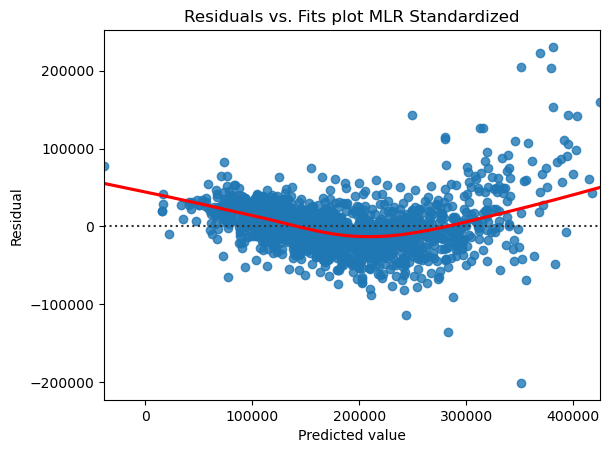

In [69]:
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot MLR Standardized',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

Let's look at this in comparison with the first MLR plot:

![Resids vs. Fits MLR](../images/resid_vs_fits_MLR.png "Resids vs. Fits MLR")


These are nearly identical, with the residuals a very small amount closer to zero in the original MLR which means that removing the garage_qual and bsmt_fin_sf features didn't have a large impact on this aspect of the model.

Checking residual/error normality

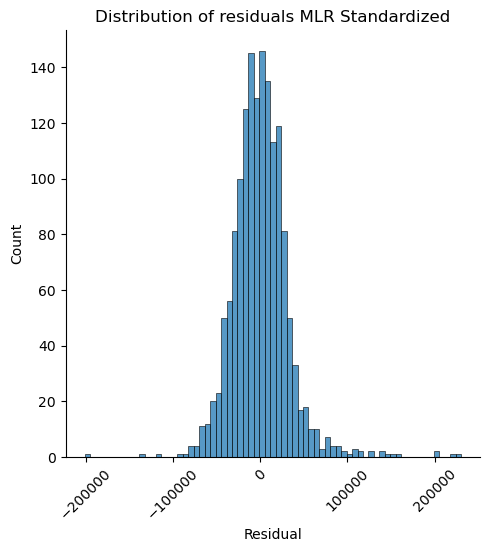

In [70]:
sns.displot(resid)\
    .set(title = 'Distribution of residuals MLR Standardized',
        xlabel = 'Residual')

plt.xticks(rotation=45);

The residuals are approximately normally distributed, which meets the linear regression assumption.

Q-Q plot

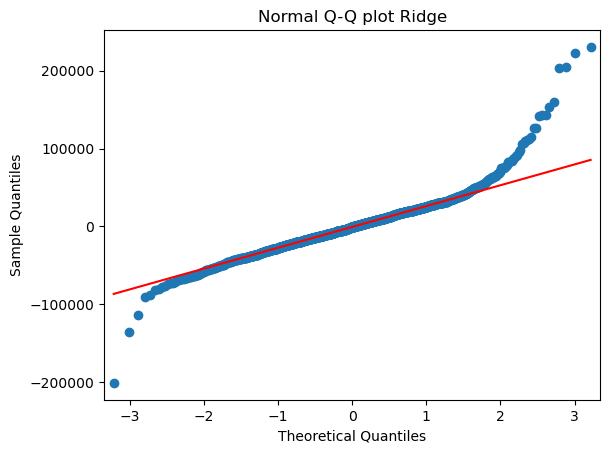

In [71]:
sm.qqplot(resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot Ridge');

Looking at this another way with the above q-q plot, we can see that many of the residuals do fall on the red line which represents a completely normal distribution.  We see the residuals diverge from the line around the second theoretical quantile.

In [72]:
# extract the coefficients and corresponding feature names from the model
{feature: f'{coef:.2f}' for feature, coef in 
 zip(ss_mlr.feature_names_in_, ss_mlr.coef_)}

{'tot_baths': '1029.05',
 'bedroom_abvgr': '-4725.68',
 'gr_liv_area': '29861.20',
 'overall_qual': '20403.78',
 'overall_cond': '3653.50',
 'garage_area': '15725.75',
 'exter_cond': '-1852.14',
 'exter_qual': '9322.21',
 'bsmt_qual': '8274.03',
 'bsmt_cond': '-1902.28',
 'bsmt_pct_fin': '9014.14',
 'kitchen_qual': '7052.53',
 'garage_cond': '-5078.06',
 'fireplaces': '6272.64'}

### Interpretation

As it relates to providing decision support for our client, these coefficient values can be intrepreted to understand the effects that each feature has on the sale price of a home.

- When evaluating each feature and coefficient value, features other than the one you are interpreting must be thought to be held constant.
- Due to the standardizing of the underlying data, these values are no longer in the original scale, meaning that, as an example, the value for `gr_liv_area` which is 29861.20 should not be thought of as adding $29861 in sale price for each square foot.  Instead, use these to indicate direction and strength of relationship between a feature and the target (sale price).  For features that were on a similar scale, like overall quality and condition, I'll interpret these values relative to each other.

Using that frame and thinking about the problem statement in addition to what we saw in our EDA, let's examine some of the relevant insights:

- The features that have the greatest positive effect on sale price are the above-grade living area, overall quality, and garage area.
- Overall quality of materials and finishes are about 5x as impactful on the sale price as the overall condition.
- Quality is significantly more important than condition in all features that had both: Overall, Exterior, and Basement.
- Increasing the amount of finished space in basements has a large positive impact on sale price.
    - More so than improving kitchen quality, adding a fireplace or a bathroom

Trying to concisely summarize this for our client, I would say that based on our model to drive an increased sale price:
- Prioritize quality of materials and finishes
- Remodeling with high quality materials is a smart move
    - With this approach you are taking advantage of both quality and condition
- Basements and exteriors are the two areas that I would target for remodeling, followed by Kitchens
- If you are considering adding square footage to your property:
    - Adding above grade sqaure feet would have the most impact
    - Adding garage square feet is still very positive, but about half the impact as the above grade square footage

### Basement Targeted Simple Linear Model

Building simple model for interpretation focused on basement finishing and quality

In [73]:
#configure X and y with features and target
X = train[['bsmt_fin_sf', 'bsmt_qual', 'tot_sf']]
y = train['saleprice']

# split for train and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=415)

In [74]:
slr_int = LinearRegression()

slr_int.fit(X_train, y_train)

LinearRegression()

#### Model Evaluation

Check cross validation score

In [75]:
# check cross val score
cross_val_score(slr_int, X_train, y_train, cv=5).mean()

0.7465241941320823

Score the model on training data

In [76]:
# slr train score
get_scores(y_train, slr_int.predict(X_train))

('R2 score: 0.75', 'RMSE: 40148.20')

Score the model on validation data

In [77]:
# slr val score
get_scores(y_val, slr_int.predict(X_val))

('R2 score: 0.73', 'RMSE: 39012.38')

This focused simple model does not fit as well as the standardized MLR model, as we can see from the lower R2 score and the increased RMSE, however what we gain from this is interpretability.  Let's look at the coefficient values from this model:

In [78]:
{feature: f'{coef:.2f}' for feature, coef in zip(slr_int.feature_names_in_ , slr_int.coef_)}

{'bsmt_fin_sf': '19.24', 'bsmt_qual': '9782.69', 'tot_sf': '68.17'}

Although this model isn't performing as well, we could interpret the coefficients as:

With all other features held constant:
- Each square foot you finish in your basement would increase the sale price by \$19.24
- Each unit of basement quality improvement would increase the sale price by \$9782.69
- Each additional square foot you can add on to your house would increase the sale price by \$68.17

Make predictions using the targeted simple linear regression model and calculate the residuals

In [79]:
#calculate residuals by creating predictions
preds = slr_int.predict(X_train)
resid = y_train - preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

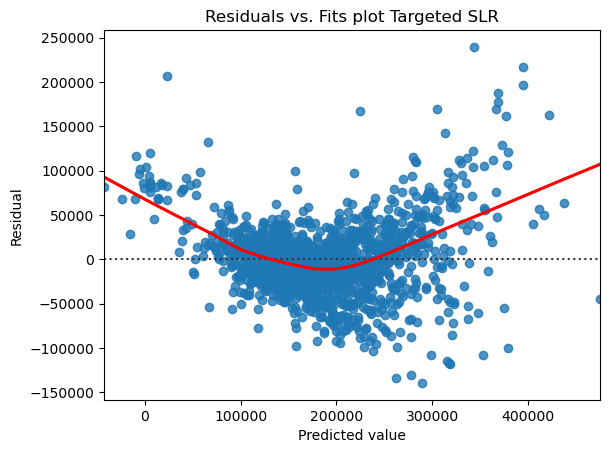

In [80]:
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot Targeted SLR',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

Let's look at this in comparison with the first MLR plot:

![Resids vs. Fits MLR](../images/resid_vs_fits_MLR.png "Resids vs. Fits MLR")


We can see how this targeted SLR model underperforms the MLR model by quite a bit.  There is more dispersion on both the low and high ends of the predicted values and in general there is more spread to the residuals overall.

Checking residual/error normality

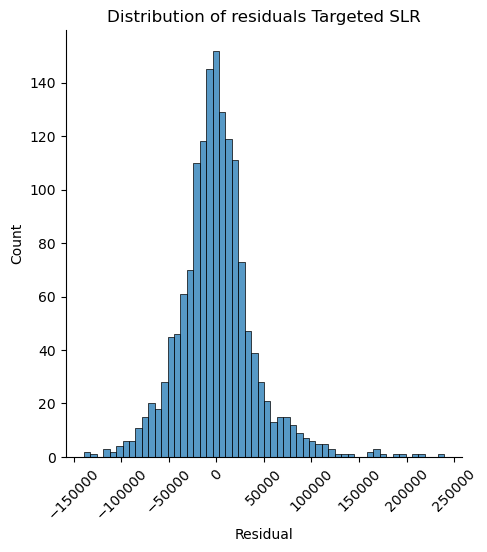

In [82]:
sns.displot(resid)\
    .set(title = 'Distribution of residuals Targeted SLR',
        xlabel = 'Residual')

plt.xticks(rotation=45);

The residuals are approximately normally distributed, which meets the linear regression assumption, but a right skew is appearing, compared to the MLR model.

Although this model is more interpretable, given the performance of the model, I would not feel comfortable quoting these values and set incorrect expectations.